<a href="https://colab.research.google.com/github/LeonimerMelo/GANs/blob/main/CIFAR10_GAN_full_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network (GAN) for Image Generation

## Overview
This script implements a deep learning GAN to generate synthetic images using the CIFAR-10 dataset. The implementation uses TensorFlow and follows these main steps:
1. Data Preparation
2. Generator and Discriminator Architecture
3. Training Process
4. Image Generation and Visualization

## Key Components

### Hyperparameters
- Latent Dimension: 100 (size of the random noise vector)
- Batch Size: 64
- Epochs: 50
- Learning Rate: 0.0002
- Beta_1 (Adam optimizer): 0.5

### Data Preprocessing
- Loads CIFAR-10 dataset
- Normalizes images to range [-1, 1]
- Ensures dataset size is a multiple of batch size

### Generator Architecture
- Takes a random noise vector as input
- Uses transposed convolutions to upsample and generate images
- Produces 32x32x3 images (CIFAR-10 image size)
- Uses BatchNormalization and LeakyReLU activations
- Final layer uses tanh activation to output images in [-1, 1] range

### Discriminator Architecture
- Convolutional neural network for binary classification
- Inputs 32x32x3 images
- Uses LeakyReLU and Dropout for regularization
- Outputs binary probability of image being real or fake

### Training Process
- Alternating training of generator and discriminator
- Uses binary cross-entropy loss
- Adam optimizer for both networks
- Tracks and plots generator and discriminator losses

### Key Training Functions
- `treino_discriminador`: Trains discriminator on real and fake images
- `treino_gerador`: Trains generator to fool the discriminator
- `treinar_gan`: Main training loop managing epoch-level training

### Visualization
- Generates sample images every 5 epochs
- Plots loss curves for generator and discriminator
- Saves generated images and loss plot

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Carregar o banco de dados
def carregar_dataset():
  # Carregar imagens do CIFAR10
  (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()

  # Normalizar imagens para o intervalo [-1, 1]
  x_train = x_train.astype('float32')
  x_train = (x_train - 127.5) / 127.5

  # Garantir que o número de amostras seja múltiplo do batch_size
  num_amostras = (len(x_train) // BATCH_SIZE) * BATCH_SIZE
  x_train = x_train[:num_amostras]

  return x_train

In [ ]:
# Construção do Gerador
def criar_gerador():
  modelo = tf.keras.Sequential([
    tf.keras.Input(shape=(LATENT_DIM,)),
    tf.keras.layers.Dense(8*8*256),
    tf.keras.layers.Reshape((8, 8, 256)),

    # Camada de convolução transposta 2D (Conv2DTranspose)
    # A necessidade de convoluções transpostas geralmente surge do desejo de usar uma transformação indo na
    # direção oposta de uma convolução normal, ou seja, de algo que tem o formato da saída de alguma convolução
    # para algo que tem o formato de sua entrada, mantendo um padrão de conectividade que seja compatível com a dita convolução.

    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(negative_slope=0.2),

    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(negative_slope=0.2),

    tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
  ])
  return modelo

In [ ]:
# Construção do Discriminador
def criar_discriminador():
  modelo = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),

    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(negative_slope=0.2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(negative_slope=0.2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return modelo

In [ ]:
# Função de treinamento com @tf.function para melhoria de desempenho
@tf.function
def treino_discriminador(imagens_reais, gerador, discriminador, ruido):
  # Gerar imagens falsas
  imagens_falsas = gerador(ruido, training=True)

  # Preparar labels
  labels_reais = tf.ones((tf.shape(imagens_reais)[0], 1))
  labels_falsos = tf.zeros((tf.shape(imagens_falsas)[0], 1))

  # Concatenar imagens reais e falsas
  imagens_combinadas = tf.concat([imagens_reais, imagens_falsas], axis=0)
  labels_combinados = tf.concat([labels_reais, labels_falsos], axis=0)

  # Treinar discriminador
  with tf.GradientTape() as tape:
      preditos = discriminador(imagens_combinadas, training=True)
      perda_discriminador = tf.keras.losses.binary_crossentropy(labels_combinados, preditos)

  # Calcular e aplicar gradientes
  gradientes = tape.gradient(perda_discriminador, discriminador.trainable_variables)
  return perda_discriminador, gradientes

In [ ]:
@tf.function
def treino_gerador(gerador, discriminador, ruido):
  # Preparar labels
  labels_enganosos = tf.ones((tf.shape(ruido)[0], 1))

  # Treinar gerador
  # A função tf.GradientTape() do TensorFlow é usada para gravar as operações executadas durante o
  # forward pass (propagação direta), de forma que depois seja possível calcular automaticamente os
  # gradientes dessas operações em relação a variáveis (geralmente pesos de um modelo).
  with tf.GradientTape() as tape:
      # Gerar imagens
      imagens_falsas = gerador(ruido, training=True)

      # Discriminador avalia imagens falsas
      preditos = discriminador(imagens_falsas, training=False)

      # Calcular perda do gerador
      perda_gerador = tf.keras.losses.binary_crossentropy(labels_enganosos, preditos)

  # Calcular e aplicar gradientes
  gradientes = tape.gradient(perda_gerador, gerador.trainable_variables)
  return perda_gerador, gradientes

In [ ]:
def treinar_gan(gerador, discriminador, dados_reais):
    # Otimizadores
    otimizador_gerador = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)
    otimizador_discriminador = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1)

    # Listas para armazenar perdas
    perdas_discriminador = []
    perdas_gerador = []

    # Preparar dataset
    dataset = tf.data.Dataset.from_tensor_slices(dados_reais)
    dataset = dataset.shuffle(10000).batch(BATCH_SIZE)

    # Loop de treinamento
    for epoch in range(EPOCHS):
        perdas_disc_epoch = []
        perdas_gen_epoch = []

        for imagens_reais in dataset:
            # Gerar ruído
            ruido = tf.random.normal([BATCH_SIZE, LATENT_DIM])

            # Treinar Discriminador
            perda_disc, gradientes_disc = treino_discriminador(imagens_reais, gerador, discriminador, ruido)

            # O método apply_gradients do otimizador (Optimizer) no Keras (ou TensorFlow) tem a função de
            # atualizar os pesos do modelo com base nos gradientes computados durante o processo de treinamento.
            # optimizer.apply_gradients(grads_and_vars)
            # grads_and_vars: é uma lista (ou outro iterável) de pares (gradiente, variável) — normalmente retornada por
            # tape.gradient(...), quando se usa tf.GradientTape. O método aplica a regra de atualização do otimizador
            # (por exemplo, SGD, Adam, RMSprop, etc.) para ajustar os pesos do modelo, reduzindo a função de perda.
            # Esse método não calcula os gradientes — ele apenas os aplica. Para calcular os gradientes, usa-se geralmente o tf.GradientTape.
            otimizador_discriminador.apply_gradients(zip(gradientes_disc, discriminador.trainable_variables))

            # Treinar Gerador
            perda_gen, gradientes_gen = treino_gerador(gerador, discriminador, ruido)
            otimizador_gerador.apply_gradients(zip(gradientes_gen, gerador.trainable_variables))

            # Armazenar perdas
            perdas_disc_epoch.append(perda_disc)
            perdas_gen_epoch.append(perda_gen)

        # Média das perdas na época
        perdas_discriminador.append(tf.reduce_mean(perdas_disc_epoch))
        perdas_gerador.append(tf.reduce_mean(perdas_gen_epoch))

        # Visualização periódica
        # if (epoch + 1) % 5 == 0:
        print(f'Época {epoch+1}: Perda Discriminador = {perdas_discriminador[-1]:.4f}, Perda Gerador = {perdas_gerador[-1]:.4f}')
        gerar_e_salvar_imagens(gerador, epoch)

    return perdas_discriminador, perdas_gerador


In [ ]:
# Função para geração e salvamento de imagens
def gerar_e_salvar_imagens(gerador, epoch):
    # Gerar imagens
    ruido = tf.random.normal([25, LATENT_DIM])
    imagens_geradas = gerador.predict(ruido)

    # Desnormalizar imagens
    imagens_geradas = 0.5 * imagens_geradas + 0.5

    # Plotar imagens
    plt.figure(figsize=(6, 6))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imagens_geradas[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'imagens_geradas_epoch_{epoch+1}.png')
    plt.show()
    plt.close()

In [ ]:
# Visualização das perdas
def plotar_perdas(perdas_discriminador, perdas_gerador):
    # plt.figure(figsize=(10, 5))
    plt.plot(perdas_discriminador, label='Perda Discriminador')
    plt.plot(perdas_gerador, label='Perda Gerador')
    plt.title('Evolução das Perdas durante Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Valor da Perda')
    plt.legend()
    plt.tight_layout()
    plt.savefig('curva_de_perdas.png')
    plt.show()
    plt.close()

In [ ]:
# Configurações e hiperparâmetros
LATENT_DIM = 100  # Dimensão do espaço latente
BATCH_SIZE = 32
LEARNING_RATE = 0.0002
BETA_1 = 0.5
EPOCHS = 10

# Configurar GPU para crescimento dinâmico de memória
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Carregar dados
print('Carregando os dados...')
dados = carregar_dataset()
print('Shape do banco de dandos:', dados.shape)

# Criar modelos
print('Criando os modelos...')
gerador = criar_gerador()
discriminador = criar_discriminador()

Carregando os dados...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape do banco de dandos: (49984, 32, 32, 3)
Criando os modelos...


Iniciando o treinamento...
Época 1: Perda Discriminador = 0.6906, Perda Gerador = 0.7430
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


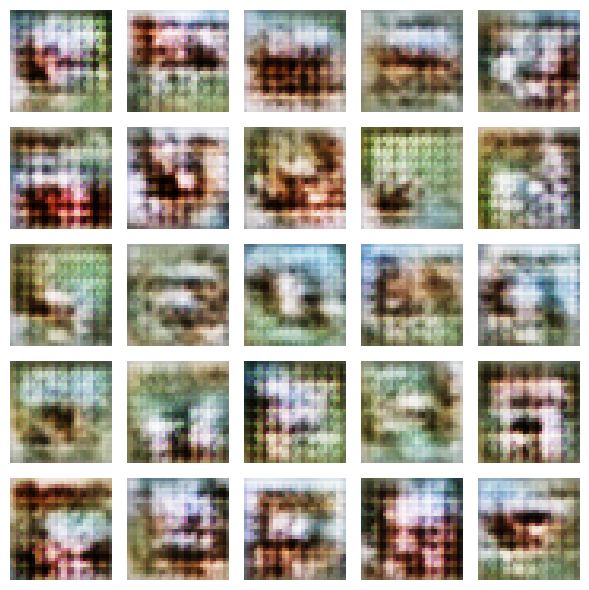

Época 2: Perda Discriminador = 0.6893, Perda Gerador = 0.7599
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


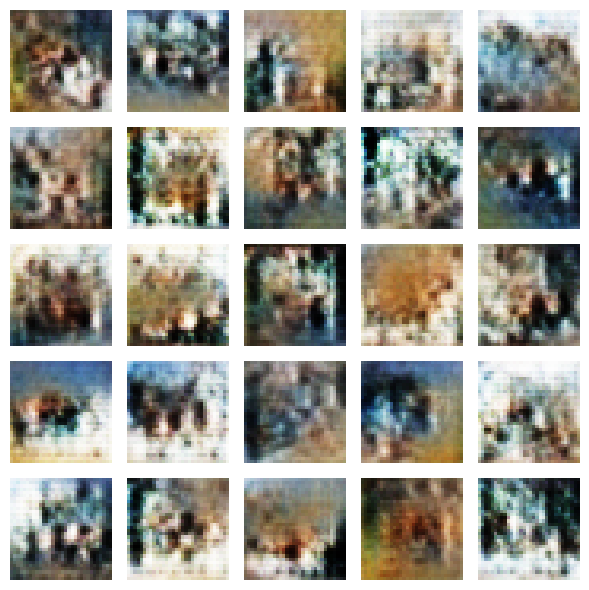

Época 3: Perda Discriminador = 0.6785, Perda Gerador = 0.8219
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


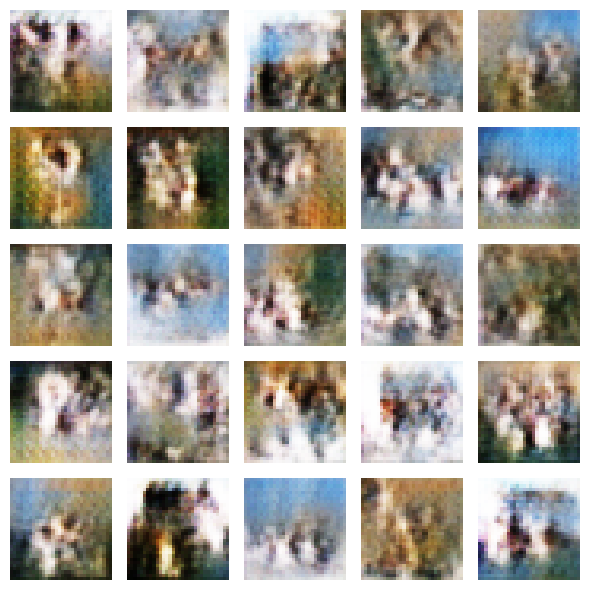

Época 4: Perda Discriminador = 0.6633, Perda Gerador = 0.8970
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


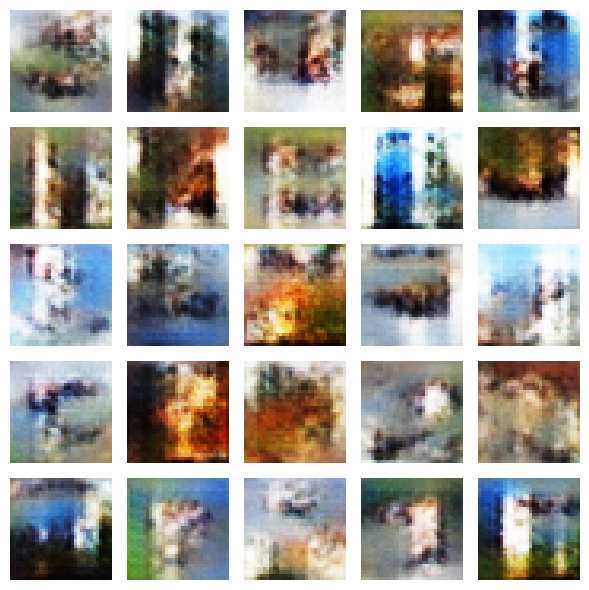

Época 5: Perda Discriminador = 0.6564, Perda Gerador = 0.9205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


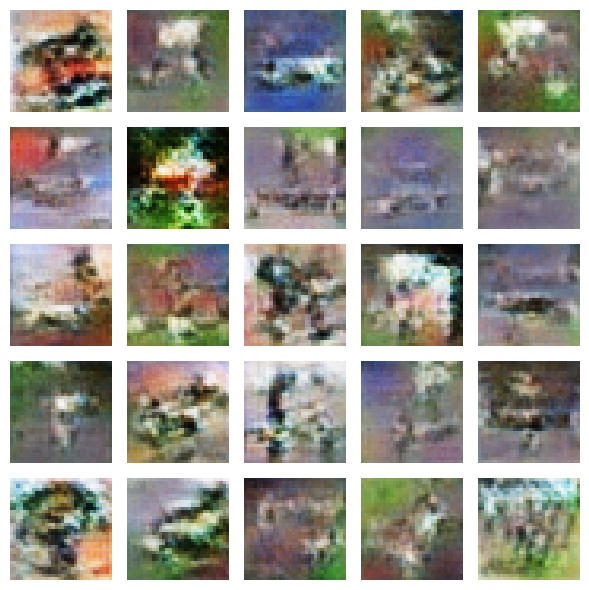

Época 6: Perda Discriminador = 0.6650, Perda Gerador = 0.9147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


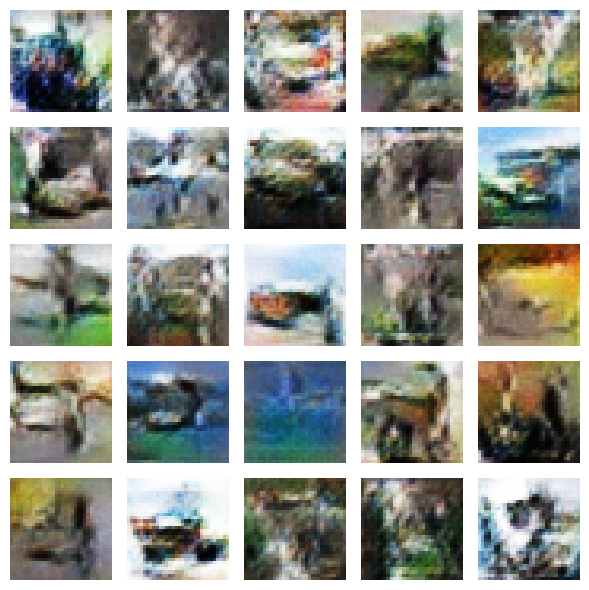

Época 7: Perda Discriminador = 0.6744, Perda Gerador = 0.8758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


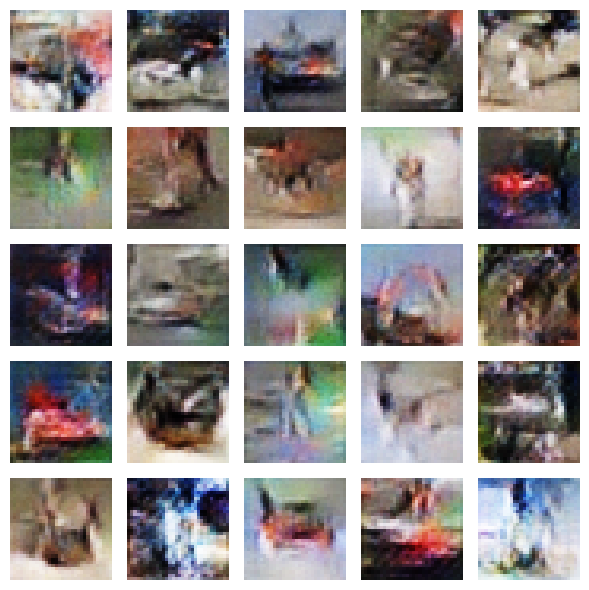

Época 8: Perda Discriminador = 0.6775, Perda Gerador = 0.8635
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


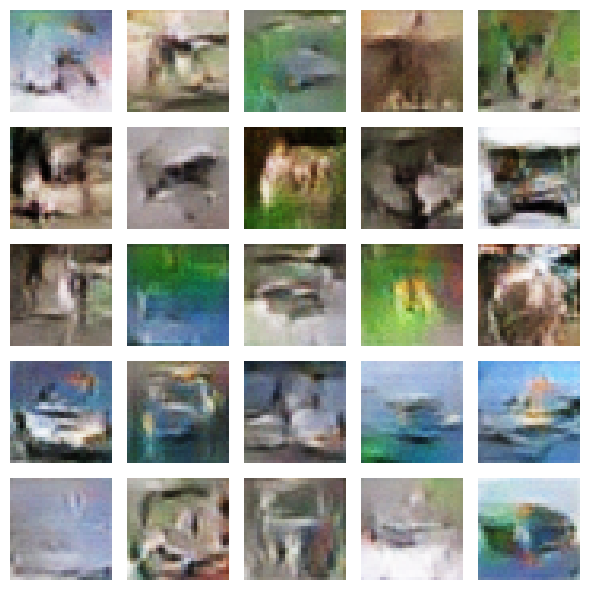

Época 9: Perda Discriminador = 0.6765, Perda Gerador = 0.8667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


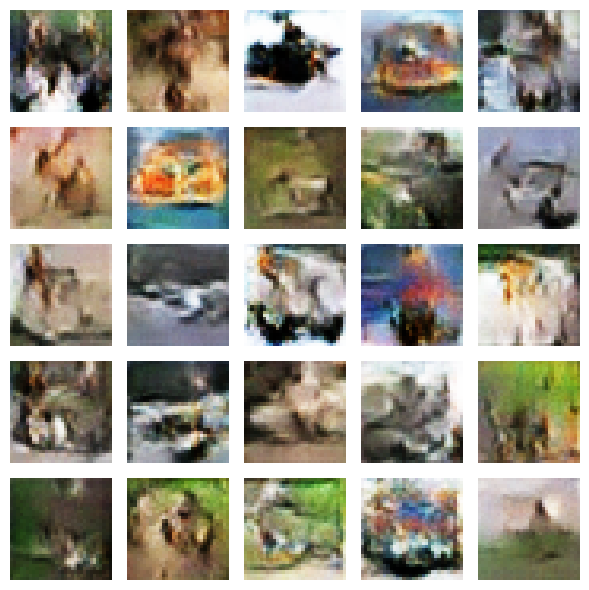

Época 10: Perda Discriminador = 0.6739, Perda Gerador = 0.8660
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


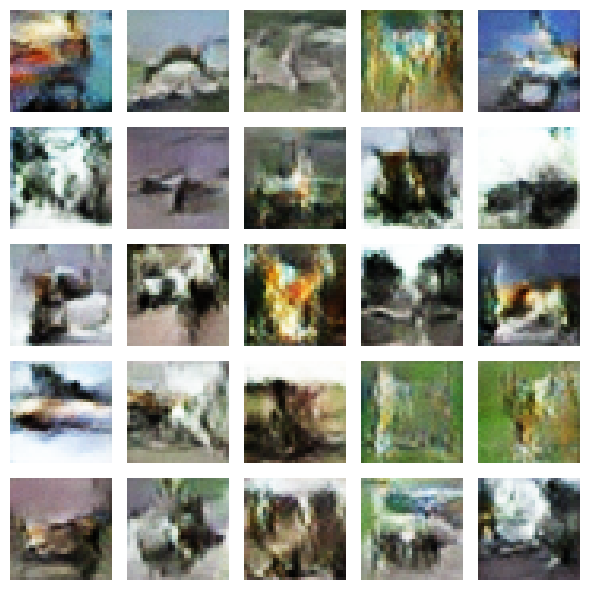

In [ ]:
# Treinar GAN
print('Iniciando o treinamento...')
perdas_discriminador, perdas_gerador = treinar_gan(gerador, discriminador, dados)

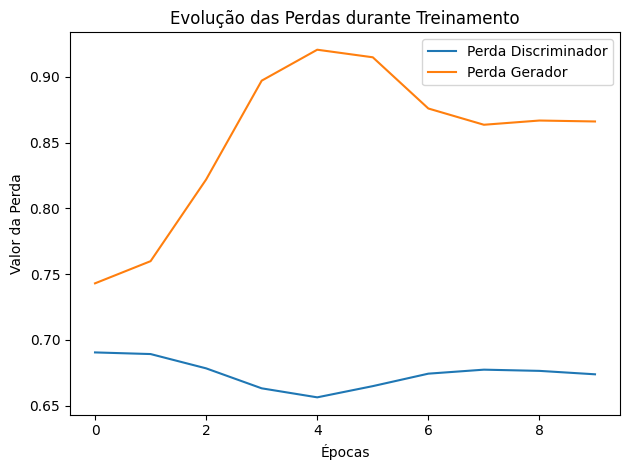

In [ ]:
# Plotar resultados de treinamento (se possível)
try:
    plotar_perdas(perdas_discriminador, perdas_gerador)
except Exception as e:
    print(f"Erro ao plotar perdas: {e}")

In [ ]:
import gc
if 'tf' in globals():
    tf.keras.backend.clear_session()
gc.collect()

In [ ]:
# caminho para salvar o modelo treinando (no drive do google)
path = '/content/drive/MyDrive/Colab Notebooks/models/'

In [ ]:
# Salvar modelos
gerador.save(path + 'gerador_model.keras')
discriminador.save(path + 'discriminador_model.keras')

In [ ]:
# carregar modelos salvos
gerador.load_weights(path + 'gerador_model.keras')
discriminador.load_weights(path + 'discriminador_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


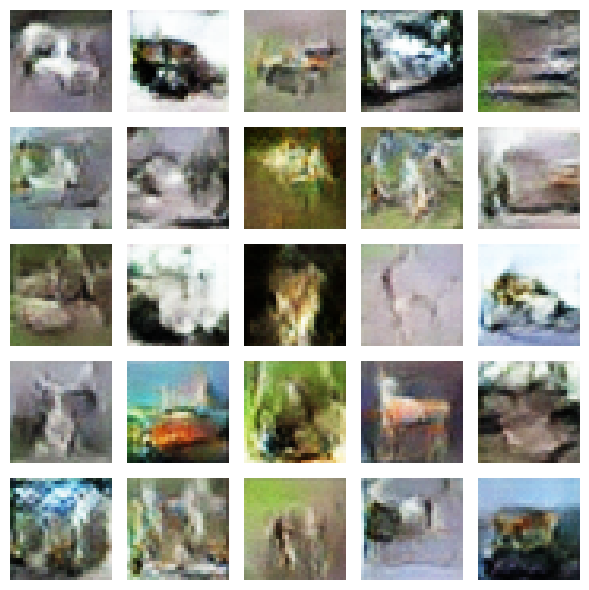

In [ ]:
# Gerar algumas imagens finais
try:
    gerar_e_salvar_imagens(gerador, EPOCHS)
except Exception as e:
    print(f"Erro ao gerar imagens finais: {e}")

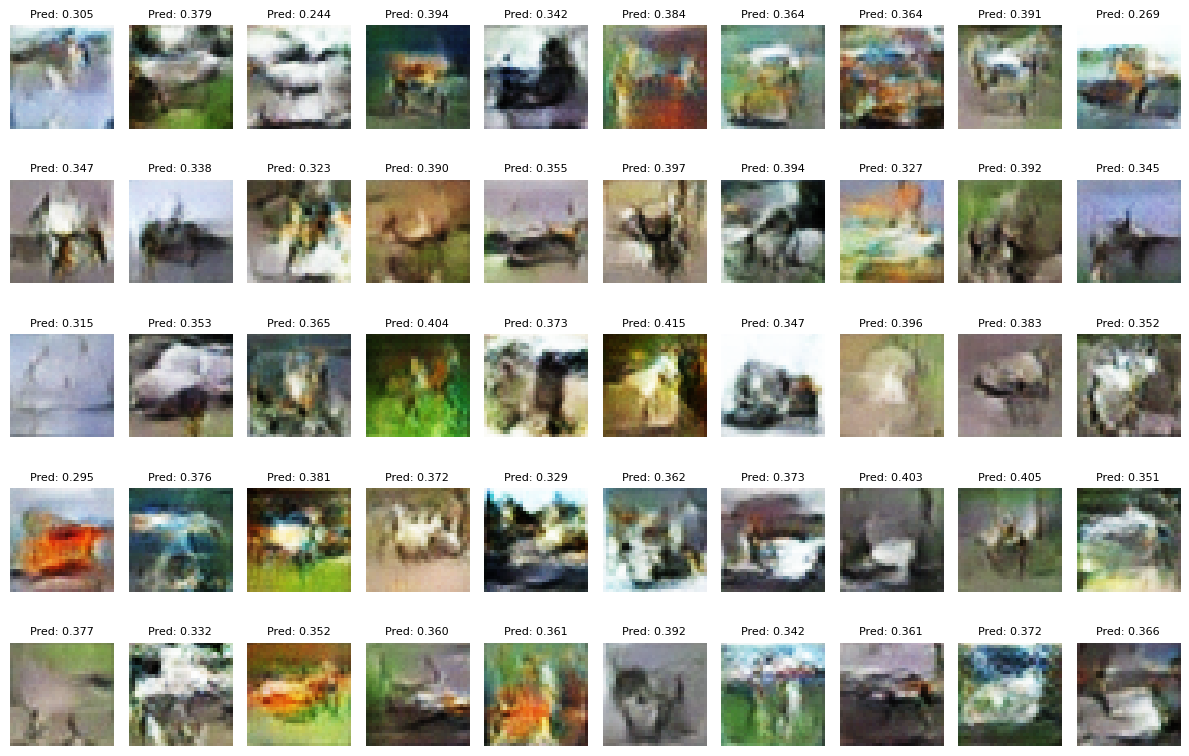

In [ ]:
def plotar_50_amostras_geradas(gerador, discriminador):
    """
    Gera 50 imagens com o gerador e plota com as predições do discriminador.

    Args:
        gerador (tf.keras.Model): Modelo gerador treinado
        discriminador (tf.keras.Model): Modelo discriminador treinado
    """
    # Gerar ruído para 50 imagens
    ruido = tf.random.normal([50, LATENT_DIM])

    # Gerar imagens
    imagens_geradas = gerador.predict(ruido, verbose=False)

    # Desnormalizar imagens
    imagens_geradas = 0.5 * imagens_geradas + 0.5

    # Obter predições do discriminador
    preditos = discriminador.predict(imagens_geradas, verbose=False)

    # Plotar imagens
    plt.figure(figsize=(12, 8))
    for i in range(50):
        plt.subplot(5, 10, i+1)
        plt.imshow(imagens_geradas[i])
        # Formatar título com predição do discriminador
        plt.title(f'Pred: {preditos[i][0]:.3f}', fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    #plt.suptitle('50 Imagens Geradas com Predições do Discriminador', fontsize=16)
    #plt.savefig('50_imagens_geradas_com_predicoes.png', dpi=300, bbox_inches='tight')
    plt.show()
    #plt.close()


# Após treinar a GAN, plotar 50 amostras
plotar_50_amostras_geradas(gerador, discriminador)